In [9]:
%load_ext autoreload
%autoreload 2

from dateutil.relativedelta import relativedelta
from dateutil.utils import today
from eolearn.core import (
    FeatureType,
    SaveTask,
    linearly_connect_tasks,
    EOWorkflow,
    EOExecutor, OutputTask,
)
from eolearn.io import get_available_timestamps, SentinelHubInputTask
from sentinelhub import SHConfig, BBox, CRS, DataCollection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
config = SHConfig(profile="sentinel-dl")

In [11]:
roi_bbox = BBox(bbox=(5.60, 52.68, 5.75, 52.63), crs=CRS.WGS84)

In [12]:
def get_last_two_timestamps(data_collection):
    today_ts = today()
    two_months_ago_ts = today_ts - relativedelta(months=2)
    time_of_interest = (two_months_ago_ts, today_ts)

    timestamps = get_available_timestamps(
        bbox=roi_bbox,
        time_interval=time_of_interest,
        data_collection=data_collection,
        config=config,
    )
    return timestamps[-2:]

In [13]:
# max cloud cover
maxcc = 0.8

# meters
resolution = 20

data_collection = DataCollection.SENTINEL2_L1C

time_interval = get_last_two_timestamps(data_collection)

input_task = SentinelHubInputTask(
    data_collection=data_collection,
    # bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"] # if not passed, it will download all
    bands_feature=(FeatureType.DATA, "L1C_data"),
    additional_data=[(FeatureType.MASK, "dataMask")],  # cloud mask
    maxcc=maxcc,
    resolution=resolution,
    config=config,  # important since we are using sentinel-dl, alternatively save ID and secret to default profile
)

besides L1C we can also get L2A, SCL, NDWI... Refer to this guide: https://github.com/sentinel-hub/eo-learn/blob/master/examples/io/SentinelHubIO.ipynb

In [14]:
save = SaveTask("eopatch_fd")
output_task = OutputTask("eopatch")

In [15]:
workflow_nodes = linearly_connect_tasks(input_task, save, output_task)
workflow = EOWorkflow(workflow_nodes)
# workflow.dependency_graph() additionally install graphviz and eo-learn[VISUALIZATION]

In [16]:
# take nodes, these are not the same as tasks!!!
input_node = workflow_nodes[0]
save_node = workflow_nodes[-2]

execution_args = [
    {
        input_node: {"bbox": roi_bbox, "time_interval": time_interval},
        save_node: {"eopatch_folder": "eopatch_file"},
    }
]

executor = EOExecutor(workflow, execution_args)

In [18]:
res = executor.run(workers=4)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

100%|██████████| 1/1 [00:06<00:00,  6.50s/it]
C:\Users\blazr\miniconda3\envs\sentinel_env\lib\site-packages\eolearn\visualization\eoexecutor.py:62: EOUserWarning: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH.
Please install the system package 'graphviz' (in addition to the python package) to have the dependency graph in the final report!
  warnings.warn(


In [21]:
res[0].outputs

{'eopatch': EOPatch(
   bbox=BBox(((5.6, 52.63), (5.75, 52.68)), crs=CRS('4326'))
   timestamps=[datetime.datetime(2024, 10, 26, 10, 56, 23)]
   data={
     L1C_data: numpy.ndarray(shape=(1, 297, 497, 13), dtype=float32)
   }
   mask={
     dataMask: numpy.ndarray(shape=(1, 297, 497, 1), dtype=bool)
   }
 )}

In [26]:
import geopandas as gpd
from pathlib import Path
from importlib import reload

Path("data/svn_border.geojson").exists()

True

In [41]:
from matplotlib import pyplot as plt
import util.region_tools as rt
reload(rt)
slo = rt.prepare_slo_shape()

country_shape = slo.geometry.values[0]

plt.axis("off")
country_width = country_shape.bounds[2] - country_shape.bounds[0]
country_height = country_shape.bounds[3] - country_shape.bounds[1]
print(f"Dimension of the area is {country_width:.0f} x {country_height:.0f} m2")
slo.plot()
plt.savefig("tst.png")

Dimension of the area is 243208 x 161608 m2


In [47]:
reload(rt)
chunks = rt.prepare_slo_chunks()
chunks

,index,index_x,index_y,geometry
0,0,0,19,"POLYGON ((368640.000 5125120.000, 368640.000 5..."
1,1,1,17,"POLYGON ((373760.000 5114880.000, 373760.000 5..."
2,2,1,18,"POLYGON ((373760.000 5120000.000, 373760.000 5..."
3,3,1,19,"POLYGON ((373760.000 5125120.000, 373760.000 5..."
4,4,1,20,"POLYGON ((373760.000 5130240.000, 373760.000 5..."
...,...,...,...,...
895,895,47,25,"POLYGON ((609280.000 5155840.000, 609280.000 5..."
896,896,47,26,"POLYGON ((609280.000 5160960.000, 609280.000 5..."
897,897,48,23,"POLYGON ((614400.000 5145600.000, 614400.000 5..."
898,898,48,24,"POLYGON ((614400.000 5150720.000, 614400.000 5..."


In [48]:
chunks.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

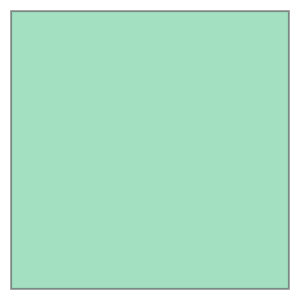

In [64]:
i_0, row_0 = (next(chunks.iterrows()))
row_0["geometry"]

In [66]:
fig, ax = plt.subplots(figsize=(30, 30))
ax.set_title("Selected 5x5 tiles from Slovenia", fontsize=25)
slo.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)
chunks.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for i, row in chunks.iterrows():
    geo = row["geometry"]
    ax.text(geo.centroid.x, geo.centroid.y, row["index"], ha="center", va="center")

plt.axis("off")
plt.savefig("box.png")